In [ ]:
import cv2
import os
import numpy as np
import random
from PIL import Image
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#For segmentation
from skimage.measure import label
from skimage.transform import resize
from skimage.segmentation import slic
from skimage.color import label2rgb

#Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Dense, Activation, Dropout, Input,Conv2D, Flatten,
                             Convolution2D, MaxPooling2D,BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

#Torch
import torch
import torch.nn as nn
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

#Scikit_learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report,
                             ConfusionMatrixDisplay, confusion_matrix)
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 30 07:09:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   40C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
tf.random.set_seed(0)
random.seed(0)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Function for generating class weights
def generate_class_weights(labels):
    # Ensure class labels start from 0
    min_label = np.min(labels)
    class_series = labels - min_label

    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=class_labels,
                                         y=class_series)
    class_weights = dict(zip(class_labels, class_weights))
    return class_weights

In [ ]:
def load_galaxy_images(data_dir, categories, target_size):
        all_images = []

        file_path = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        for img in file_path:
            image = cv2.imread(img)
            resized_images=cv2.resize(image, target_size)
            resized_images = (resized_images * 255).astype(np.uint8)
            pil_images = Image.fromarray(resized_images)
            all_images.append(pil_images)

        return all_images

In [ ]:
input_size = 200

# transforms for training data
train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])


# transforms for test data
test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

In [ ]:
g_im = '/content/drive/MyDrive/Data/star_galaxy/pics/galaxy'
s_im = '/content/drive/MyDrive/Data/star_galaxy/pics/star'

categories = ['g', 's']

g_img = load_galaxy_images(g_im, categories=categories[0], target_size=(200,200))
s_img = load_galaxy_images(s_im, categories=categories[1], target_size=(200,200))

all_data = g_img + s_img
np.shape(all_data)

(1325, 200, 200, 3)

In [ ]:
# Labels
galaxies_labels = np.zeros(780)
stars_labels = np.ones(545)

all_labels = np.concatenate([galaxies_labels, stars_labels])
len(all_labels)

1325

### Classic CNN

In [ ]:
X_train_list=[]
y_train_list=[]
X_test_list=[]
y_test_list=[]
models=[]
Y_pred=[]
accs=[]
cons=[]
aucs=[]
fprs=[]
tprs=[]
TP_list = []
FP_list = []
TN_list = []
FN_list = []
test_indx=[]

b_size = 64
e_num = 30

for i in range (10):
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)), test_size=0.25, shuffle=True, random_state=None)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    test_indx.append(test_indices)

    y_train_encoded = to_categorical(y_train, num_classes=2)
    class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(s_img))}

    # Training data
    transformed_X_train=[]
    for i in range(len(X_train)):
      transformed_train_images = train_transform(X_train[i])
      new_image = np.transpose(transformed_train_images, (1, 2, 0))
      transformed_X_train.append(new_image)

    # Testing data
    transformed_X_test=[]
    for j in range(len(X_test)):
      transformed_test_images = test_transform(X_test[j])
      new_images = np.transpose(transformed_test_images, (1, 2, 0))
      transformed_X_test.append(new_images)

    # input
    x = Input(shape=(200,200,3))

    #hidden layers
    c0 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same")(x)
    b0 = BatchNormalization()(c0)
    m0 = MaxPooling2D(pool_size=(2, 2))(b0)
    d0 = Dropout(0.1)(m0)

    c1 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same")(m0)
    b1 = BatchNormalization()(c1)
    m1 = MaxPooling2D(pool_size=(2, 2))(b1)
    d1 = Dropout(0.1)(m1)

    c2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")(m1)
    b2 = BatchNormalization()(c2)
    m2 = MaxPooling2D(pool_size=(2, 2))(b2)
    d2 = Dropout(0.1)(m2)

    f = Flatten()(m2)

    de0 = Dense(64, activation='relu')(f)
    de1 = Dense(32, activation='relu')(de0)
    de2 = Dense(2, activation='softmax')(de1)

    model = Model(inputs=x, outputs=de2, name="cnn_transformer_galaxy_nonegalaxy")
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    # Callback Functions
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=b_size,
    epochs=e_num,
    verbose = 1,
    class_weight=class_weights,
    callbacks=es,
    validation_split=0.1
    )
    models.append(history)

    y_pred = model.predict(np.array(transformed_X_test))
    y_pred_labels = np.argmax(y_pred, axis=1)
    Y_pred.append(y_pred_labels)

    con0 = metrics.confusion_matrix(y_test, y_pred_labels)
    cons.append(con0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
    TN_list.append(tn)
    FP_list.append(fp)
    FN_list.append(fn)
    TP_list.append(tp)

    acc = metrics.accuracy_score(y_test, y_pred_labels)
    accs.append(acc)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_labels)
    fprs.append(fpr)
    tprs.append(tpr)

    auc = metrics.roc_auc_score(y_test, y_pred_labels)
    aucs.append(auc)

Epoch 1/30
14/14 [==============================] - 41s 2s/step - loss: 1.9105 - accuracy: 0.5823 - val_loss: 8.3102 - val_accuracy: 0.5300
Epoch 2/30
14/14 [==============================] - 5s 328ms/step - loss: 0.8343 - accuracy: 0.7010 - val_loss: 4.4952 - val_accuracy: 0.6900
Epoch 3/30
14/14 [==============================] - 5s 329ms/step - loss: 0.7706 - accuracy: 0.6865 - val_loss: 5.3902 - val_accuracy: 0.5400
Epoch 4/30
14/14 [==============================] - 5s 329ms/step - loss: 0.6933 - accuracy: 0.7469 - val_loss: 1.1269 - val_accuracy: 0.6900
Epoch 5/30
14/14 [==============================] - 5s 330ms/step - loss: 0.5675 - accuracy: 0.7514 - val_loss: 2.4107 - val_accuracy: 0.5500
Epoch 6/30
14/14 [==============================] - 5s 329ms/step - loss: 0.3874 - accuracy: 0.8298 - val_loss: 0.7252 - val_accuracy: 0.6900
Epoch 7/30
14/14 [==============================] - 5s 329ms/step - loss: 0.3287 - accuracy: 0.8600 - val_loss: 0.6884 - val_accuracy: 0.6900
Epoch 8/

In [ ]:
print(np.mean(accs), np.std(accs))

0.7548192771084337 0.033600204258757455


In [ ]:
output_el_path = '/content/drive/MyDrive/Data/win_classifier_material'
import os
import pickle
pickle_el_filename = 'test_indx_cnn_img_galaxy_nonegalaxy.pickle'
pickle_el_filepath = os.path.join(output_el_path, pickle_el_filename)

with open(pickle_el_filepath, 'wb') as pickle_file:
    pickle.dump(test_indx, pickle_file)


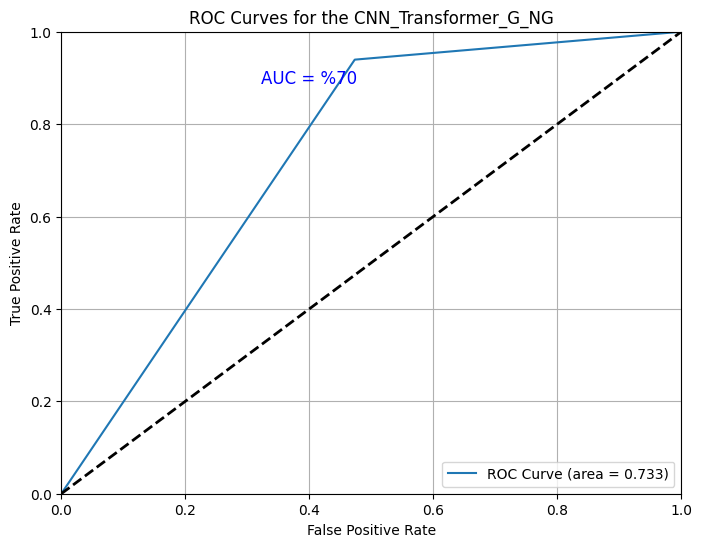

In [ ]:
class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fprs[3], tprs[3], lw=1.5, label='ROC Curve (area = {:.3f})'.format(aucs[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for the CNN_Transformer_G_NG')
plt.text(0.4, 0.9, 'AUC = %70', fontsize=12, color='blue', ha='center', va='center')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import pickle
Pkl_Filename = "/content/drive/MyDrive/Data/star_galaxy/best_models/best_cnn_transformer_galaxy_star_acc79_tss41.sav"
with open(Pkl_Filename, 'wb') as file:
    pickle.dump(models[9], file)

### VGG16

In [ ]:
X_train_list=[]
y_train_list=[]
X_test_list=[]
y_test_list=[]
models=[]
Y_pred=[]
accs=[]
cons=[]
aucs=[]
fprs=[]
tprs=[]
TP_list = []
FP_list = []
TN_list = []
FN_list = []
test_indx = []

b_size =64
e_num = 30

for i in range (10):
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)), test_size=0.25, shuffle=True, random_state=None)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    test_indx.append(test_indices)

    y_train_encoded = to_categorical(y_train, num_classes=2)
    class_weights = {0: len(all_data) / (2*780), 1: len(all_data) / (2*545)}

    # Training data
    transformed_X_train=[]
    for i in range(len(X_train)):
      transformed_train_images = train_transform(X_train[i])
      new_image = np.transpose(transformed_train_images, (1, 2, 0))
      transformed_X_train.append(new_image)

    # Testing data
    transformed_X_test=[]
    for j in range(len(X_test)):
      transformed_test_images = test_transform(X_test[j])
      new_images = np.transpose(transformed_test_images, (1, 2, 0))
      transformed_X_test.append(new_images)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(64, activation='relu')(x)  # Add your custom layers here
    output = Dense(2, activation='softmax')(x)  # 3 classes, so 3 output units with softmax activation

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=b_size,
    epochs=e_num,
    verbose = 1,
    callbacks=es,
    class_weight=class_weights,
    validation_split=0.1
    )
    models.append(history)

    y_pred = model.predict(np.array(transformed_X_test))
    y_pred_labels = np.argmax(y_pred, axis=1)
    Y_pred.append(y_pred_labels)

    con0 = metrics.confusion_matrix(y_test, y_pred_labels)
    cons.append(con0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
    TN_list.append(tn)
    FP_list.append(fp)
    FN_list.append(fn)
    TP_list.append(tp)

    acc = metrics.accuracy_score(y_test, y_pred_labels)
    accs.append(acc)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_labels)
    fprs.append(fpr)
    tprs.append(tpr)

    auc = metrics.roc_auc_score(y_test, y_pred_labels)
    aucs.append(auc)

Epoch 1/30
14/14 [==============================] - 4s 199ms/step - loss: 1.1901 - accuracy: 0.6473 - val_loss: 0.4927 - val_accuracy: 0.7300
Epoch 2/30
14/14 [==============================] - 2s 180ms/step - loss: 0.4310 - accuracy: 0.7962 - val_loss: 0.5137 - val_accuracy: 0.7400
Epoch 3/30
14/14 [==============================] - 2s 179ms/step - loss: 0.3337 - accuracy: 0.8499 - val_loss: 0.3771 - val_accuracy: 0.8000
Epoch 4/30
14/14 [==============================] - 2s 180ms/step - loss: 0.2533 - accuracy: 0.9026 - val_loss: 0.4090 - val_accuracy: 0.8200
Epoch 5/30
14/14 [==============================] - 2s 180ms/step - loss: 0.1804 - accuracy: 0.9451 - val_loss: 0.3326 - val_accuracy: 0.8400
Epoch 6/30
14/14 [==============================] - 2s 180ms/step - loss: 0.1509 - accuracy: 0.9642 - val_loss: 0.3516 - val_accuracy: 0.8400
Epoch 7/30
14/14 [==============================] - 2s 180ms/step - loss: 0.1277 - accuracy: 0.9731 - val_loss: 0.3395 - val_accuracy: 0.8400
Epoch 

In [ ]:
print(np.mean(accs), np.max(aucs))

0.8081325301204819 0.839621935242373


In [ ]:
output_el_path = '/content/drive/MyDrive/Data/win_classifier_material'
import os
import pickle
pickle_el_filename = 'y_test_list_vgg_img_galaxy_nonegalaxy.pickle'
pickle_el_filepath = os.path.join(output_el_path, pickle_el_filename)

with open(pickle_el_filepath, 'wb') as pickle_file:
    pickle.dump(y_test_list, pickle_file)


In [ ]:
def metric(tp, fp, fn, tn):
   acu = (tp + tn) / (tp + tn + fn + fp)
   pre_p = tp / (tp + fp)
   pre_n = tn / (tn + fn)
   recal_p = tp / (tp + fn)
   recal_n = tn / (tn + fp)
   f1_p = (2 * (pre_p) * (recal_p)) / ((pre_p) + (recal_p))
   f1_n = (2 * (pre_n) * (recal_n)) / ((pre_n) + (recal_n))
   hss1 = (tp - fp) / (tp + fn)
   hss2 = (2 * ((tp * tn) - (fn * fp))) / (((tp + fn) * (tn + fn)) + ((tp + fp) * (tn + fp)))
   ch = ((tp + fp) * (tp + fn)) / (tp + fn + tn + fp)
   gs = (tp - ch) / (tp + fp + fn - ch)
   tss = (tp / (tp + fn)) - (fp / (fp + tn))
   return acu, pre_p, pre_n, recal_p, recal_n, hss1, tss, f1_p, f1_n, hss2, gs

In [ ]:
acus=[]
pre_ps=[]
pre_ns=[]
recal_ps=[]
recal_ns=[]
hss1s=[]
tsss=[]
f1_ps=[]
f1_ns=[]
hss2s=[]
gss=[]

# Calculate metrics for each set of TP, FP, FN, TN values
performance_metrics = []
for i in range(10):
    acu, pre_p, pre_n, recal_p, recal_n, hss1, tss, f1_p, f1_n, hss2, gs = metric(TP_list[i], FP_list[i], FN_list[i], TN_list[i])
    acus.append(acu)
    pre_ps.append(pre_p)
    pre_ns.append(pre_n)
    recal_ps.append(recal_p)
    recal_ns.append(recal_n)
    hss1s.append(hss1)
    tsss.append(tss)
    f1_ps.append(f1_p)
    f1_ns.append(f1_n)
    hss2s.append(hss2)
    gss.append(gs)

acus_mean = np.mean(acus)
acus_std = np.std(acus)

pre_ps_mean = np.mean(pre_ps)
pre_ps_std = np.std(pre_ps)

pre_ns_mean = np.mean(pre_ns)
pre_ns_std = np.std(pre_ns)

recal_ps_mean = np.mean(recal_ps)
recal_ps_std = np.std(recal_ps)

recal_ns_mean = np.mean(recal_ns)
recal_ns_std = np.std(recal_ns)

hss1s_mean = np.mean(hss1s)
hss1s_std = np.std(hss1s)

tsss_mean = np.mean(tsss)
tsss_std = np.std(tsss)

f1_ps_mean = np.mean(f1_ps)
f1_ps_std = np.std(f1_ps)

f1_ns_mean = np.mean(f1_ns)
f1_ns_std = np.std(f1_ns)

hss2s_mean = np.mean(hss2s)
hss2s_std = np.std(hss2s)

gss_mean = np.mean(gss)
gss_std = np.std(gss)

auc_mean = np.mean(aucs)
auc_std = np.std(aucs)

In [ ]:
print("Mean and Standard Deviation Values:")
print("Accuracy - Mean:", acus_mean, "  Std:", acus_std)
print("Precision Positive - Mean:", pre_ps_mean, "  Std:", pre_ps_std)
print("Precision Negative - Mean:", pre_ns_mean, "  Std:", pre_ns_std)
print("F1 Positive - Mean:", f1_ps_mean, "  Std:", f1_ps_std)
print("F1 Negative - Mean:", f1_ns_mean, "  Std:", f1_ns_std)
print("Recall Positive - Mean:", recal_ps_mean, "  Std:", recal_ps_std)
print("Recall Negative - Mean:", recal_ns_mean, "  Std:", recal_ns_std)
print("HSS1 - Mean:", hss1s_mean, "  Std:", hss1s_std)
print("HSS2 - Mean:", hss2s_mean, "  Std:", hss2s_std)
print("GS - Mean:", gss_mean, "  Std:", gss_std)
print("TSS - Mean:", tsss_mean, "  Std:", tsss_std)
print("AUC - Mean:", auc_mean, "  Std:", auc_std)

Mean and Standard Deviation Values:
Accuracy - Mean: 0.8280120481927711   Std: 0.019863538667225965
Precision Positive - Mean: 0.8033840861265178   Std: 0.058740322550326705
Precision Negative - Mean: 0.8503342857284893   Std: 0.02865844214598222
F1 Positive - Mean: 0.7867256482182864   Std: 0.02255547785084489
F1 Negative - Mean: 0.8550336826595725   Std: 0.020851438983969153
Recall Positive - Mean: 0.7776200634168515   Std: 0.05620887179191325
Recall Negative - Mean: 0.8629791059472989   Std: 0.05309260696124855
HSS1 - Mean: 0.5788711972106008   Std: 0.04815075263854159
HSS2 - Mean: 0.6428177053831665   Std: 0.03815239106467891
GS - Mean: 0.47484864561536694   Std: 0.04298245308359821
TSS - Mean: 0.6405991693641504   Std: 0.03624249829204909
AUC - Mean: 0.8202995846820753   Std: 0.01812124914602452


In [ ]:
output_el_path = '/content/drive/MyDrive/Data/star_galaxy'
import os
import pickle

pickle_el_filename = 'tprs_vgg16_transformer_galaxy_nonegalaxy.pickle'
pickle_el_filepath = os.path.join(output_el_path, pickle_el_filename)

with open(pickle_el_filepath, 'wb') as pickle_file:
    pickle.dump(tprs, pickle_file)


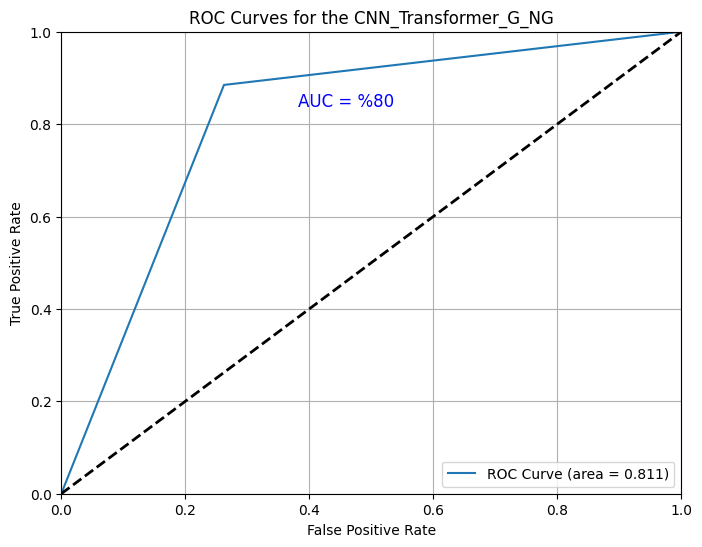

In [ ]:
class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fprs[3], tprs[3], lw=1.5, label='ROC Curve (area = {:.3f})'.format(aucs[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for the CNN_Transformer_G_NG')
plt.text(0.46, 0.85, 'AUC = %80', fontsize=12, color='blue', ha='center', va='center')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import pickle
Pkl_Filename = "/content/drive/MyDrive/Data/star_galaxy/best_models/best_vgg16_transformer_galaxy_star_acc80_tss60.sav"
with open(Pkl_Filename, 'wb') as file:
    pickle.dump(models[7], file)

### ResNet50

In [ ]:
X_train_list=[]
y_train_list=[]
X_test_list=[]
y_test_list=[]
models=[]
Y_pred=[]
accs=[]
cons=[]
aucs=[]
fprs=[]
tprs=[]
TP_list = []
FP_list = []
TN_list = []
FN_list = []
test_indx=[]

b_size =64
e_num = 30

for i in range (10):
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)), test_size=0.25, shuffle=True, random_state=None)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    test_indx.append(test_indices)

    y_train_encoded = to_categorical(y_train, num_classes=2)
    class_weights = {0: len(all_data) / (2*780), 1: len(all_data) / (2*545)}

    # Training data
    transformed_X_train=[]
    for i in range(len(X_train)):
      transformed_train_images = train_transform(X_train[i])
      new_image = np.transpose(transformed_train_images, (1, 2, 0))
      transformed_X_train.append(new_image)

    # Testing data
    transformed_X_test=[]
    for j in range(len(X_test)):
      transformed_test_images = test_transform(X_test[j])
      new_images = np.transpose(transformed_test_images, (1, 2, 0))
      transformed_X_test.append(new_images)

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(64, activation='relu')(x)  # Add your custom layers here
    output = Dense(2, activation='softmax')(x)  # 3 classes, so 3 output units with softmax activation

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=b_size,
    epochs=e_num,
    verbose = 1,
    callbacks=es,
    class_weight=class_weights,
    validation_split=0.1
    )
    models.append(history)

    y_pred = model.predict(np.array(transformed_X_test))
    y_pred_labels = np.argmax(y_pred, axis=1)
    Y_pred.append(y_pred_labels)

    con0 = metrics.confusion_matrix(y_test, y_pred_labels)
    cons.append(con0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
    TN_list.append(tn)
    FP_list.append(fp)
    FN_list.append(fn)
    TP_list.append(tp)

    acc = metrics.accuracy_score(y_test, y_pred_labels)
    accs.append(acc)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_labels)
    fprs.append(fpr)
    tprs.append(tpr)

    auc = metrics.roc_auc_score(y_test, y_pred_labels)
    aucs.append(auc)

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/30
14/14 [==============================] - 10s 390ms/step - loss: 4.8048 - accuracy: 0.6327 - val_loss: 1.7304 - val_accuracy: 0.6900
Epoch 2/30
14/14 [==============================] - 1s 102ms/step - loss: 0.7314 - accuracy: 0.6965 - val_loss: 0.5422 - val_accuracy: 0.7400
Epoch 3/30
14/14 [==============================] - 1s 102ms/step - loss: 0.4583 - accuracy: 0.7783 - val_loss: 0.6788 - val_accuracy: 0.7000
Epoch 4/30
14/14 [==============================] - 1s 102ms/step - loss: 0.2880 - accuracy: 0.8791 - val_loss: 0.8012 - val_accuracy: 0.7100
Epoch 5/30
14/14 [==============================] - 1s 102ms/step - loss: 0.2216 - accuracy: 0.9160 - val_loss: 0.6080 - val_accuracy: 0.7400
Epoch 6/30
14/14 [==============================] - 1s 101ms/step - loss: 0.1376 - accuracy: 0.9653 - val_loss: 0.5811 - val_accuracy: 0.7800
Epoch 7/30
14/14 [==============================] - 1s 101ms/step - loss: 0.1093 -

In [ ]:
print(np.mean(accs), np.max(aucs))

0.7403614457831325 0.7716015001299618


In [ ]:
output_el_path = '/content/drive/MyDrive/Data/win_classifier_material'
import os
import pickle
pickle_el_filename = 'test_indx_resnet_img_galaxy_nonegalaxy.pickle'
pickle_el_filepath = os.path.join(output_el_path, pickle_el_filename)

with open(pickle_el_filepath, 'wb') as pickle_file:
    pickle.dump(test_indx, pickle_file)


In [ ]:
acus=[]
pre_ps=[]
pre_ns=[]
recal_ps=[]
recal_ns=[]
hss1s=[]
tsss=[]
f1_ps=[]
f1_ns=[]
hss2s=[]
gss=[]

# Calculate metrics for each set of TP, FP, FN, TN values
performance_metrics = []
for i in range(10):
    acu, pre_p, pre_n, recal_p, recal_n, hss1, tss, f1_p, f1_n, hss2, gs = metric(TP_list[i], FP_list[i], FN_list[i], TN_list[i])
    acus.append(acu)
    pre_ps.append(pre_p)
    pre_ns.append(pre_n)
    recal_ps.append(recal_p)
    recal_ns.append(recal_n)
    hss1s.append(hss1)
    tsss.append(tss)
    f1_ps.append(f1_p)
    f1_ns.append(f1_n)
    hss2s.append(hss2)
    gss.append(gs)

acus_mean = np.mean(acus)
acus_std = np.std(acus)

pre_ps_mean = np.mean(pre_ps)
pre_ps_std = np.std(pre_ps)

pre_ns_mean = np.mean(pre_ns)
pre_ns_std = np.std(pre_ns)

recal_ps_mean = np.mean(recal_ps)
recal_ps_std = np.std(recal_ps)

recal_ns_mean = np.mean(recal_ns)
recal_ns_std = np.std(recal_ns)

hss1s_mean = np.mean(hss1s)
hss1s_std = np.std(hss1s)

tsss_mean = np.mean(tsss)
tsss_std = np.std(tsss)

f1_ps_mean = np.mean(f1_ps)
f1_ps_std = np.std(f1_ps)

f1_ns_mean = np.mean(f1_ns)
f1_ns_std = np.std(f1_ns)

hss2s_mean = np.mean(hss2s)
hss2s_std = np.std(hss2s)

gss_mean = np.mean(gss)
gss_std = np.std(gss)

auc_mean = np.mean(aucs)
auc_std = np.std(aucs)

In [ ]:
print("Mean and Standard Deviation Values:")
print("Accuracy - Mean:", acus_mean, "  Std:", acus_std)
print("Precision Positive - Mean:", pre_ps_mean, "  Std:", pre_ps_std)
print("Precision Negative - Mean:", pre_ns_mean, "  Std:", pre_ns_std)
print("F1 Positive - Mean:", f1_ps_mean, "  Std:", f1_ps_std)
print("F1 Negative - Mean:", f1_ns_mean, "  Std:", f1_ns_std)
print("Recall Positive - Mean:", recal_ps_mean, "  Std:", recal_ps_std)
print("Recall Negative - Mean:", recal_ns_mean, "  Std:", recal_ns_std)
print("HSS1 - Mean:", hss1s_mean, "  Std:", hss1s_std)
print("HSS2 - Mean:", hss2s_mean, "  Std:", hss2s_std)
print("GS - Mean:", gss_mean, "  Std:", gss_std)
print("TSS - Mean:", tsss_mean, "  Std:", tsss_std)
print("AUC - Mean:", auc_mean, "  Std:", auc_std)

Mean and Standard Deviation Values:
Accuracy - Mean: 0.8123493975903615   Std: 0.01547911464762601
Precision Positive - Mean: 0.7857109451631871   Std: 0.047953172573712496
Precision Negative - Mean: 0.8368902871889873   Std: 0.03392433011467447
F1 Positive - Mean: 0.7658720281418752   Std: 0.029171862203449164
F1 Negative - Mean: 0.842327955243835   Std: 0.015142941375052794
Recall Positive - Mean: 0.7558664263459315   Std: 0.07460725360883269
Recall Negative - Mean: 0.8515361160781116   Std: 0.04902883661953475
HSS1 - Mean: 0.5415527062988781   Std: 0.0388685302493664
HSS2 - Mean: 0.6097940274725102   Std: 0.03422833770438199
GS - Mean: 0.4395070501871102   Std: 0.03540161672461704
TSS - Mean: 0.6074025424240432   Std: 0.040064194439347535
AUC - Mean: 0.8037012712120216   Std: 0.020032097219673767


In [ ]:
output_el_path = '/content/drive/MyDrive/Data/star_galaxy'
import os
import pickle

pickle_el_filename = 'aucs_resnet50_transformer_galaxy_nonegalaxy.pickle'
pickle_el_filepath = os.path.join(output_el_path, pickle_el_filename)

with open(pickle_el_filepath, 'wb') as pickle_file:
    pickle.dump(aucs, pickle_file)


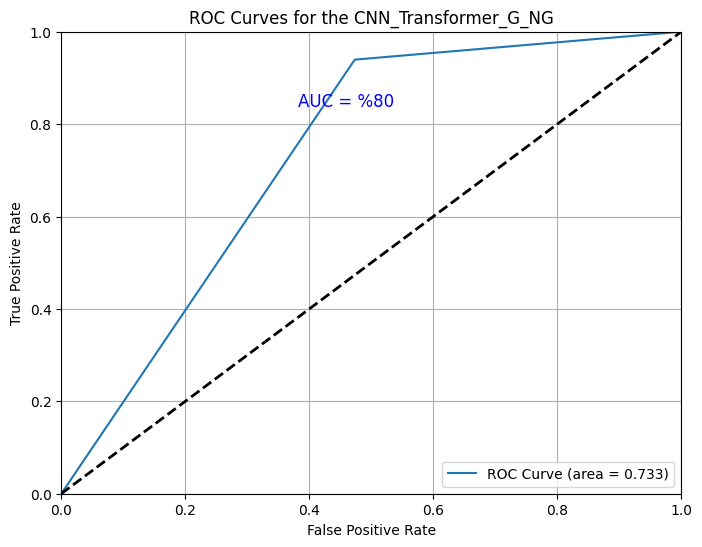

In [ ]:
class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fprs[3], tprs[3], lw=1.5, label='ROC Curve (area = {:.3f})'.format(aucs[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for the CNN_Transformer_G_NG')
plt.text(0.46, 0.85, 'AUC = %70', fontsize=12, color='blue', ha='center', va='center')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import pickle
Pkl_Filename = "/content/drive/MyDrive/Data/star_galaxy/best_models/best_resnet50_transformer_galaxy_star_acc80_tss41.sav"
with open(Pkl_Filename, 'wb') as file:
    pickle.dump(models[7], file)

#تمام

#### Define and fit the CNN model

In [ ]:
X_list=[]
y_list=[]
models=[]
Y_pred=[]
accs=[]
cons=[]
aucs=[]
fprs=[]
tprs=[]

random.seed(0)
b_size = 64
e_num = 100


for i in range (20):
    X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.25, shuffle=True, random_state=None)

    # Training data
    transformed_X_train=[]
    for i in range(len(X_train)):
      transformed_train_images = train_transform(X_train[i])
      new_image = np.transpose(transformed_train_images, (1, 2, 0))
      transformed_X_train.append(new_image)

    # Testing data
    transformed_X_test=[]
    for j in range(len(X_test)):
      transformed_test_images = test_transform(X_test[j])
      new_images = np.transpose(transformed_test_images, (1, 2, 0))
      transformed_X_test.append(new_images)

    y_train_encoded = to_categorical(y_train, num_classes=2)
    X_list.append(transformed_X_train)
    y_list.append(y_train_encoded)

    # input
    x = Input(shape=(200,200,3))

    #hidden layers
    c0 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding="same")(x)
    b0 = BatchNormalization()(c0)
    m0 = MaxPooling2D(pool_size=(2, 2))(b0)
    d0 = Dropout(0.1)(m0)

    c1 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same")(m0)
    b1 = BatchNormalization()(c1)
    m1 = MaxPooling2D(pool_size=(2, 2))(b1)
    d1 = Dropout(0.1)(m1)

    c2 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same")(m1)
    b2 = BatchNormalization()(c2)
    m2 = MaxPooling2D(pool_size=(2, 2))(b2)
    d2 = Dropout(0.1)(m2)

    f = Flatten()(m2)

    de0 = Dense(128, activation='relu')(f)
    de1 = Dense(64, activation='relu')(de0)
    de2 = Dense(2, activation='softmax')(de1)

    model = Model(inputs=x, outputs=de2, name="cnn_transformer_star_galaxy")
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    # Callback Functions
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=b_size,
    epochs=e_num,
    verbose = 1,
    callbacks=es,
    validation_split=0.1
    )
    models.append(history)

    y_pred = model.predict(np.array(transformed_X_test))
    y_pred_labels = np.argmax(y_pred, axis=1)
    Y_pred.append(y_pred_labels)

    con0 = metrics.confusion_matrix(y_test, y_pred_labels)
    cons.append(con0)

    acc = accuracy_score(y_test, y_pred_labels)
    accs.append(acc)

    fpr, tpr, _ = roc_curve(y_test,  y_pred_labels)
    fprs.append(fpr)
    tprs.append(tpr)

    auc = metrics.roc_auc_score(y_test, y_pred_labels)
    aucs.append(auc)

##### Model 1

In [ ]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3,3), strides=2, input_shape=(424, 424, 1), padding="same"))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))  # Change output units to 2 for binary classification

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
model.summary()


##### Model 2

In [ ]:
# Set seed for reproducibility
random.seed(0)

b_size =32
e_num = 10

# input
x = Input(shape=(424,424,3))

#hidden layers
c0 = Conv2D(8, kernel_size=(3,3), strides=(1,1), padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling2D(pool_size=(2, 2))(b0)
# d0 = Dropout(0.1)(m0)

c1 = Conv2D(16, kernel_size=(3,3), strides=(1,1), padding="same")(m0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling2D(pool_size=(2, 2))(b1)
# d1 = Dropout(0.1)(m1)

c2 = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding="same")(m1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling2D(pool_size=(2, 2))(b2)
# d2 = Dropout(0.1)(m2)

f = Flatten()(m2)

de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(2, activation='softmax')(de1)

model = Model(inputs=x, outputs=de2, name="cnn_transformer_star_galaxy")
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()


Model: "cnn_transformer_star_galaxy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 424, 424, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 424, 424, 8)       80        
                                                                 
 batch_normalization (Batch  (None, 424, 424, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 212, 212, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 212, 212, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 212

In [ ]:
history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    class_weight = class_weights,
    batch_size=b_size,
    epochs=e_num,
    verbose = 1,
    callbacks=es
)

Epoch 1/10
32/32 [==============================] - 154s 5s/step - loss: 3.0183 - accuracy: 0.5780
Epoch 2/10
32/32 [==============================] - 144s 4s/step - loss: 1.1277 - accuracy: 0.6415
Epoch 3/10
32/32 [==============================] - 143s 4s/step - loss: 0.6089 - accuracy: 0.7351
Epoch 4/10
32/32 [==============================] - 143s 4s/step - loss: 0.3736 - accuracy: 0.8258
Epoch 5/10
32/32 [==============================] - 149s 5s/step - loss: 0.4182 - accuracy: 0.8489
Epoch 6/10
32/32 [==============================] - 144s 4s/step - loss: 0.3535 - accuracy: 0.8640
Epoch 7/10
32/32 [==============================] - 140s 4s/step - loss: 0.3794 - accuracy: 0.8318
Epoch 8/10
32/32 [==============================] - 143s 4s/step - loss: 0.1989 - accuracy: 0.9225
Epoch 9/10
32/32 [==============================] - 144s 4s/step - loss: 0.0689 - accuracy: 0.9799
Epoch 10/10
32/32 [==============================] - 143s 4s/step - loss: 0.0409 - accuracy: 0.9940


In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
tn, fp, fn, tp=confusion_matrix(y_test, y_pred_labels).ravel()

11/11 [==============================] - 23s 2s/step


In [ ]:
acc=accuracy_score(y_test, y_pred_labels)
con0 = confusion_matrix(y_test, y_pred_labels)
tss = (tp / (tp + fn)) - (fp / (fp + tn))
print(con0,acc,tss)

[[102  43]
 [ 56 131]] 0.7018072289156626 0.4039830352203578


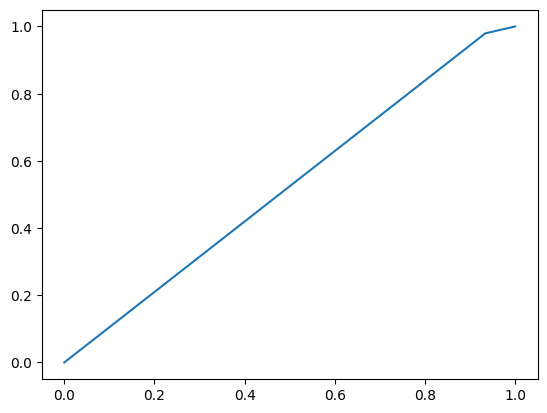

In [ ]:
plt.plot(fpr,tpr)
plt.show()

In [ ]:
# tn, fp, fn, tp=confusion_matrix(y_test, y_pred_labels).ravel()

In [ ]:
# tss = (tp/(tp+fn))-(fp/(fp+tn))
# print(tss)

-0.00990099009900991


In [ ]:
fp = []
tp = []
for j in range(10, 98, 15):
    j /= 100  # Convert j back to its original floating-point value
    batch_size = 32
    NUM_EPOCH = 10

    X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=j)
    X_train=X_train.astype(np.uint8)
    y_train=y_train.astype(np.uint8)
    # X_test = X_test.reshape((X_test.shape[0], 903, 1))
    # y_train_encoded = to_categorical(y_train, num_classes=2)
    # y_test_encoded = to_categorical(y_test, num_classes=2)

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=NUM_EPOCH, callbacks=[lr_scheduler])
    y_pred = model.predict(X_test)

    y_pred_labels = np.argmax(y_pred, axis=1)

    fpr, tpr, _ = roc_curve(y_test,  y_pred_labels)
    fp.append(fpr)
    tp.append(tpr)

AttributeError: 'list' object has no attribute 'astype'

In [ ]:
for i in range(len(fp)):
    plt.plot(fp[i], tp[i], label=f'test_size {i+1}')

plt.title('CNN + Original')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


In [ ]:
batch_size = 32
NUM_EPOCH = 10
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
tsss = []
pred_list = []
for i in range(10):
   L1 = np.random.randint(0, len(star_img), 260)
   L2 = np.random.randint(0, len(galaxy_img), 350)
   all_data = np.concatenate([star_arr[L1,:,:], galaxy_arr[L2,:,:]])
   all_labels = np.concatenate([stars_labels[L1], galaxies_labels[L2]])
   X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.1)
   y_train_encoded = to_categorical(y_train, num_classes=2)
   y_test_encoded = to_categorical(y_test, num_classes=2)
   history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=NUM_EPOCH, callbacks=[lr_scheduler])
   y_pred = model.predict(X_test)
   y_pred_labels = np.argmax(y_pred, axis=1)
   pred_list.append(y_pred_labels)
   con0 = confusion_matrix(np.argmax(y_test_encoded, axis=1), y_pred_labels)
   tp = con0[0,0]
   fn = con0[0,1]
   fp = con0[1,0]
   tn = con0[1,1]
   tss = (tp/(tp+fn))-(fp/(fp+tn))
   tsss.append(tss)


Epoch 1/10


18/18 [==============================] - 8s 317ms/step - loss: 19.1698 - accuracy: 0.6084 - lr: 0.0010
Epoch 2/10
18/18 [==============================] - 4s 191ms/step - loss: 1.6979 - accuracy: 0.8142 - lr: 0.0010
Epoch 3/10
18/18 [==============================] - 4s 208ms/step - loss: 0.8851 - accuracy: 0.8197 - lr: 0.0010
Epoch 4/10
18/18 [==============================] - 4s 224ms/step - loss: 0.2133 - accuracy: 0.9381 - lr: 0.0010
Epoch 5/10
18/18 [==============================] - 4s 214ms/step - loss: 0.0665 - accuracy: 0.9690 - lr: 0.0010
Epoch 6/10
18/18 [==============================] - 4s 197ms/step - loss: 0.0398 - accuracy: 0.9891 - lr: 0.0010
Epoch 7/10
18/18 [==============================] - 3s 182ms/step - loss: 0.0254 - accuracy: 0.9909 - lr: 1.0000e-04
Epoch 8/10
18/18 [==============================] - 3s 185ms/step - loss: 0.0231 - accuracy: 0.9927 - lr: 1.0000e-04
Epoch 9/10
18/18 [==============================] - 4s 247ms/step - loss: 0.0223 - a

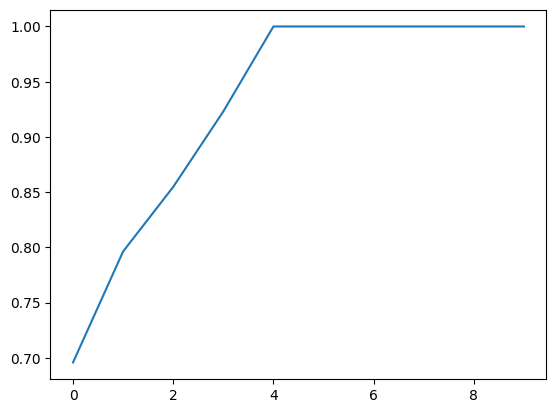

In [ ]:
plt.plot(tsss)

In [ ]:
mean_tss = np.mean(tsss)
std_tss = np.std(tsss)
print(mean_tss, std_tss)

0.9269979230539576 0.10379415185787724


In [ ]:
# batch_size = 32
# NUM_EPOCH = 10

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(np.array(X_train), y_train,
#                     batch_size=batch_size,
#                     epochs=NUM_EPOCH,
#                     callbacks=[lr_scheduler])

Epoch 1/10
70/70 [==============================] - 26s 355ms/step - loss: 3.8616 - accuracy: 0.4667 - lr: 0.0010
Epoch 2/10
70/70 [==============================] - 24s 348ms/step - loss: 0.8959 - accuracy: 0.5959 - lr: 0.0010
Epoch 3/10
70/70 [==============================] - 24s 348ms/step - loss: 0.7441 - accuracy: 0.6831 - lr: 0.0010
Epoch 4/10
70/70 [==============================] - 24s 348ms/step - loss: 0.5393 - accuracy: 0.7854 - lr: 0.0010
Epoch 5/10
70/70 [==============================] - 24s 349ms/step - loss: 0.3642 - accuracy: 0.8713 - lr: 0.0010
Epoch 6/10
70/70 [==============================] - 25s 350ms/step - loss: 0.2488 - accuracy: 0.9182 - lr: 0.0010
Epoch 7/10
70/70 [==============================] - 24s 348ms/step - loss: 0.0973 - accuracy: 0.9866 - lr: 1.0000e-04
Epoch 8/10
70/70 [==============================] - 24s 347ms/step - loss: 0.0708 - accuracy: 0.9933 - lr: 1.0000e-04
Epoch 9/10
70/70 [==============================] - 24s 347ms/step - loss: 0.056

#### Performance and test the model

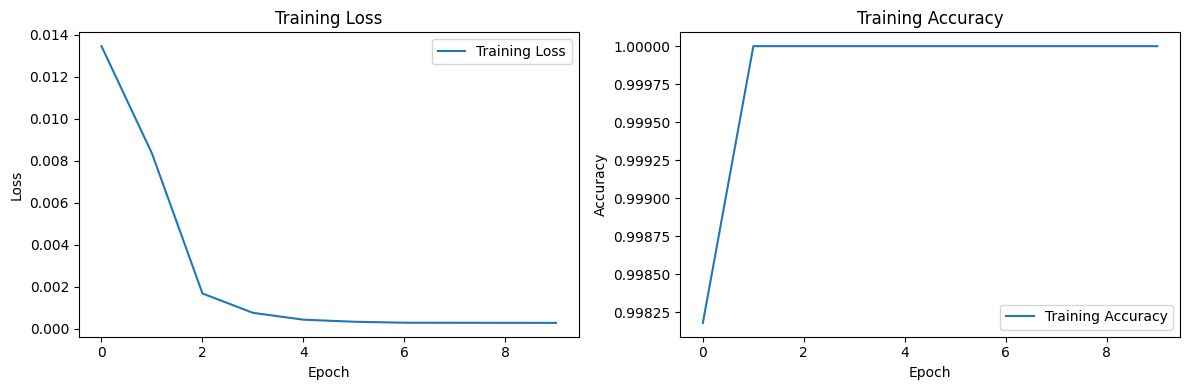

In [ ]:
import matplotlib.pyplot as plt
import json

# Define the function to plot training history
def plot_training(history):
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training(history)
plt.show()

In [ ]:
y_pred = model.predict(np.array(X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_labels)
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


2/2 [==============================] - 0s 64ms/step
[[32  0]
 [ 0 29]]


NameError: name 'categories' is not defined

<Figure size 800x600 with 0 Axes>